In [11]:
import os
import time
import glob
import pickle
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from baseline import *

In [2]:
seed = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed(seed)

## Prepare Dataset

In [3]:
train_G, prediction_links = pickle.load(open('input_{}.pkl'.format(1), 'rb'))

node_features = pickle.load(open('node_features.pkl', 'rb'))
text_features = np.array(list(node_features.values()))
nnodes = text_features.shape[0]

pca = PCA(n_components=100)
pca.fit(text_features)
emb_features = pca.transform(text_features)
emb_features = torch.from_numpy(emb_features).to(device).float()
    
adj = {k:{k} for k in range(nnodes)}
for node in list(train_G.nodes()):
    adj[node] = adj[node].union(list(train_G[node]))
adj = [np.sort(list(v)) for k,v in adj.items()]

## Parameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nlayer = 2
dims = [100]*(nlayer+1)
dropout = 0.4

lr = 0.005
weight_decay = 0.0005

patience = 50
nepoch = 10000

## Link Prediction Supervised Training

In [5]:
X_train, X_test, y_train, y_test = train_test_split(prediction_links[:,:-1], prediction_links[:,-1])
y_train, y_test = torch.from_numpy(y_train).float().to(device), torch.from_numpy(y_test).float().to(device)

In [6]:
def evaluate(cos_sim, labels):
    pred = expit(cos_sim)>0.5
    f1, accuracy = f1_score(labels, pred), accuracy_score(labels, pred)
    return accuracy, f1

In [7]:
pdist = nn.PairwiseDistance()
edges = np.array(list(train_G.edges()))

def edge_diff(embeds):
    diff = pdist(embeds[edges[:,0]], embeds[edges[:,1]])
    return torch.mean(diff).cpu().item()

def embed_diff(embeds, prev_embeds):
    diff = pdist(embeds, prev_embeds)
    return torch.mean(diff).cpu().item()

In [8]:
cos = nn.CosineSimilarity()

def sup_train(model, optimizer, epoch, prev_embeds):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    
    embeds = model(emb_features, adj)
    lp_input = torch.stack([embeds[X_train[:,0]], embeds[X_train[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_train)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_train.cpu().numpy())
    curr_edge_diff = edge_diff(embeds)
    curr_embed_diff = embed_diff(embeds, prev_embeds)
    curr_input_diff = embed_diff(embeds, emb_features)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%1==0:
        print('Epoch: {} || Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f} || Edge_diff: {:.4f}, Embed_diff: {:.4f}, Input_diff: {:.4f} || Time: {:.4f}s'
              .format(epoch, loss.item(), accuracy, f1, curr_edge_diff, curr_embed_diff, curr_input_diff, time.time()-t))
    
    return loss.item(), curr_edge_diff, curr_embed_diff, curr_input_diff, embeds

In [9]:
def sup_test(model):
    model.eval()
    
    embeds = model(emb_features, adj)
    lp_input = torch.stack([embeds[X_test[:,0]], embeds[X_test[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_test)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_test.cpu().numpy())
    
    print('Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}'.format(loss.item(), accuracy, f1))

In [10]:
t_total = time.time()

model = GraphSAGEModel(dims=dims, dropout=dropout, nlayer=nlayer, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

prev_embeds = emb_features
loss_values, edge_diffs, embed_diffs, input_diffs = [], [], [], []
bad_counter, best, best_epoch = 0, nepoch+1, 0
for epoch in range(nepoch):
    loss_value, curr_edge_diff, curr_embed_diff, curr_input_diff, prev_embeds = sup_train(model, optimizer, epoch, prev_embeds)
    
    loss_values.append(loss_value)
    edge_diffs.append(curr_edge_diff)
    embed_diffs.append(curr_embed_diff)
    input_diffs.append(curr_input_diff)
    
    torch.save(model.state_dict(), 'Supervised/{}.pkl'.format(epoch))
    
    if loss_values[-1] < best:
        best, best_epoch, bad_counter = loss_values[-1], epoch, 0
    else:
        bad_counter += 1
                
    if bad_counter == patience:
        break
        
    files = glob.glob('Supervised/*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0].split('/')[-1])
        if epoch_nb < best_epoch:
            os.remove(file) 
    
files = glob.glob('Supervised/*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0].split('/')[-1])
    if epoch_nb > best_epoch:
        os.remove(file) 
        
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('Supervised/{}.pkl'.format(best_epoch)))

sup_test(model)

Epoch: 0 || Loss: 0.6857, Acc: 0.5016, F1: 0.6680 || Edge_diff: 0.3807, Embed_diff: 1.3241, Input_diff: 1.3241 || Time: 5.9874s
Epoch: 1 || Loss: 0.6494, Acc: 0.5016, F1: 0.6680 || Edge_diff: 0.4294, Embed_diff: 0.7673, Input_diff: 1.3263 || Time: 5.8208s
Epoch: 2 || Loss: 0.6270, Acc: 0.5016, F1: 0.6680 || Edge_diff: 0.4716, Embed_diff: 0.7326, Input_diff: 1.3273 || Time: 5.8024s
Epoch: 3 || Loss: 0.6109, Acc: 0.5034, F1: 0.6684 || Edge_diff: 0.5179, Embed_diff: 0.7350, Input_diff: 1.3283 || Time: 5.8675s
Epoch: 4 || Loss: 0.6029, Acc: 0.5205, F1: 0.6659 || Edge_diff: 0.5572, Embed_diff: 0.7657, Input_diff: 1.3278 || Time: 5.9309s
Epoch: 5 || Loss: 0.5970, Acc: 0.5658, F1: 0.6797 || Edge_diff: 0.5641, Embed_diff: 0.7864, Input_diff: 1.3284 || Time: 5.9105s
Epoch: 6 || Loss: 0.5957, Acc: 0.6090, F1: 0.6887 || Edge_diff: 0.5604, Embed_diff: 0.7902, Input_diff: 1.3298 || Time: 5.7700s
Epoch: 7 || Loss: 0.5917, Acc: 0.6616, F1: 0.7214 || Edge_diff: 0.5517, Embed_diff: 0.7778, Input_diff: 

Epoch: 64 || Loss: 0.5603, Acc: 0.8514, F1: 0.8418 || Edge_diff: 0.4395, Embed_diff: 0.5271, Input_diff: 1.3146 || Time: 5.8075s
Epoch: 65 || Loss: 0.5610, Acc: 0.8472, F1: 0.8379 || Edge_diff: 0.4389, Embed_diff: 0.5266, Input_diff: 1.3137 || Time: 5.8396s
Epoch: 66 || Loss: 0.5606, Acc: 0.8449, F1: 0.8357 || Edge_diff: 0.4389, Embed_diff: 0.5161, Input_diff: 1.3149 || Time: 5.8875s
Epoch: 67 || Loss: 0.5608, Acc: 0.8379, F1: 0.8299 || Edge_diff: 0.4361, Embed_diff: 0.5113, Input_diff: 1.3136 || Time: 5.8110s
Epoch: 68 || Loss: 0.5619, Acc: 0.8389, F1: 0.8296 || Edge_diff: 0.4386, Embed_diff: 0.5207, Input_diff: 1.3137 || Time: 5.9574s
Epoch: 69 || Loss: 0.5604, Acc: 0.8431, F1: 0.8352 || Edge_diff: 0.4405, Embed_diff: 0.5287, Input_diff: 1.3160 || Time: 5.8098s
Epoch: 70 || Loss: 0.5600, Acc: 0.8431, F1: 0.8346 || Edge_diff: 0.4377, Embed_diff: 0.5217, Input_diff: 1.3143 || Time: 5.8890s
Epoch: 71 || Loss: 0.5605, Acc: 0.8475, F1: 0.8376 || Edge_diff: 0.4374, Embed_diff: 0.5308, Inpu

Epoch: 128 || Loss: 0.5636, Acc: 0.8413, F1: 0.8296 || Edge_diff: 0.4340, Embed_diff: 0.5092, Input_diff: 1.3150 || Time: 5.8363s
Epoch: 129 || Loss: 0.5611, Acc: 0.8496, F1: 0.8376 || Edge_diff: 0.4228, Embed_diff: 0.5195, Input_diff: 1.3087 || Time: 5.7965s
Epoch: 130 || Loss: 0.5625, Acc: 0.8503, F1: 0.8373 || Edge_diff: 0.4265, Embed_diff: 0.5110, Input_diff: 1.3064 || Time: 5.7788s
Epoch: 131 || Loss: 0.5619, Acc: 0.8529, F1: 0.8396 || Edge_diff: 0.4264, Embed_diff: 0.5171, Input_diff: 1.3056 || Time: 5.9145s
Epoch: 132 || Loss: 0.5613, Acc: 0.8470, F1: 0.8339 || Edge_diff: 0.4306, Embed_diff: 0.5149, Input_diff: 1.3075 || Time: 5.7778s
Epoch: 133 || Loss: 0.5611, Acc: 0.8503, F1: 0.8373 || Edge_diff: 0.4264, Embed_diff: 0.5086, Input_diff: 1.3066 || Time: 5.7968s
Epoch: 134 || Loss: 0.5615, Acc: 0.8485, F1: 0.8369 || Edge_diff: 0.4249, Embed_diff: 0.5186, Input_diff: 1.3076 || Time: 5.9154s
Epoch: 135 || Loss: 0.5631, Acc: 0.8428, F1: 0.8299 || Edge_diff: 0.4275, Embed_diff: 0.52

Text(0.5, 1.0, 'Training Loss Curve')

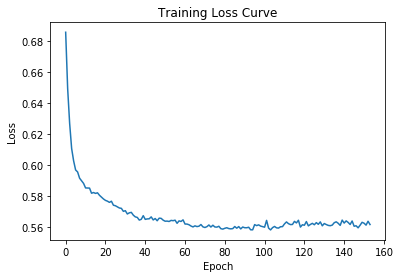

In [13]:
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

Text(0.5, 1.0, 'Training Edge-wise Distance Curve')

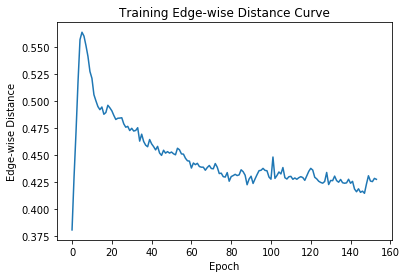

In [16]:
plt.plot(edge_diffs)
plt.xlabel('Epoch')
plt.ylabel('Edge-wise Distance')
plt.title('Training Edge-wise Distance Curve')

Text(0.5, 1.0, 'Change in Embedding Curve')

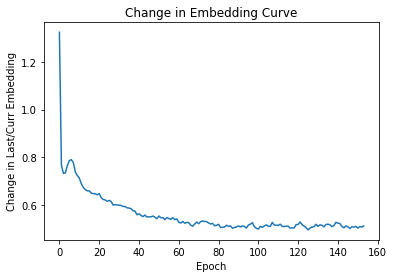

In [18]:
plt.plot(embed_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Last/Curr Embedding')
plt.title('Change in Embedding Curve')

Text(0.5, 1.0, 'Change in Input/Output Curve')

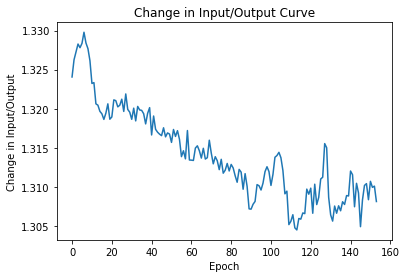

In [19]:
plt.plot(input_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Input/Output')
plt.title('Change in Input/Output Curve')

In [20]:
pickle.dump((loss_values, edge_diffs, embed_diffs, input_diffs), open('supervised_experiments.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)